In [1]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt
import git
import os, sys

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(os.path.join(path_git, 'utils'))
from functions import *

os.chdir(path_git)


2024-11-12 12:23:34.471116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Parámetros de la simulación

# choose a number of time steps
look_back = 45

# Cantidad de valores por cada paso temporal
n_features = 1

# Cantidad de pasos que queremos predecir hacia adelante
window_size = 110

# longitud de la cadena izquierda
len_left_chain = 500

# longitud de la cadena derecha
len_right_chain = 720

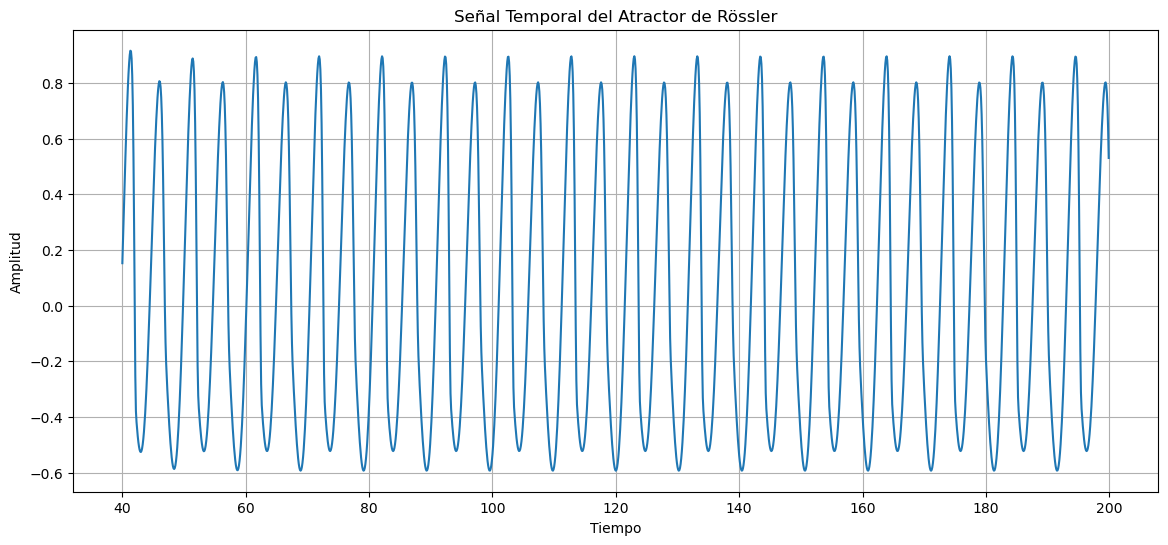

In [3]:
# Generamos la señal temporal

# Parámetros para el atractor de Rössler
a = 0.2
b = 0.2
c = 5.7

# Paso de tiempo y número de pasos
dt = 0.1
num_steps = 2000

# Vector de tiempos
t = np.arange(0, num_steps * dt, dt)

# Generar la secuencia temporal para el atractor de Rössler
raw_seq, _, _ = rossler_attractor(a, b, c, dt, num_steps)

# Normalizar la secuencia
maximo = np.max(np.abs(raw_seq))
raw_seq = raw_seq / maximo

# Acortar la secuencia para que no sea tan larga y tenga una amplitud similar
raw_seq = raw_seq[400:]
t = t[400:]

# Graficar la señal temporal
plt.figure(figsize=(14, 6))
plt.plot(t, raw_seq)
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal Temporal del Atractor de Rössler')
plt.grid(True)
plt.show()

In [4]:
raw_seq_1 = raw_seq[0:len_left_chain]
t_1 = t[0:len_left_chain]

print(len(raw_seq_1),len_left_chain)

500 500


In [5]:
raw_seq_2 = raw_seq[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]
t_2 = t[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

print(len(raw_seq_2),len_right_chain)

720 720


In [6]:
t_window = t[len_left_chain:len_left_chain+window_size]
raw_seq_window = raw_seq[len_left_chain:len_left_chain+window_size]
print(len(raw_seq_window),window_size)

110 110


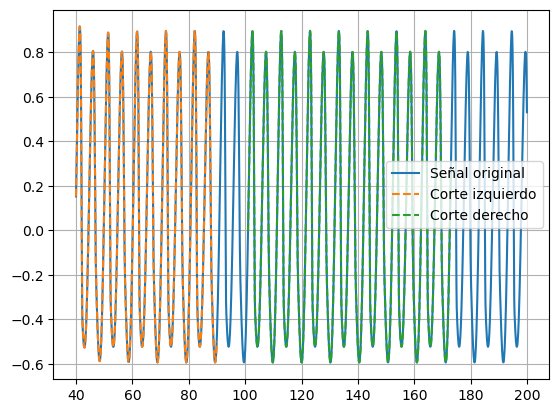

In [7]:
plt.plot(t,raw_seq, label='Señal original')
plt.plot(t_1,raw_seq_1, '--', label='Corte izquierdo')
plt.plot(t_2,raw_seq_2, '--', label='Corte derecho')
plt.grid()
plt.legend()
plt.show()

In [8]:
print('t_1 limits:',t_1[0],t_1[-1])
print('t_window limits:', t_window[0],t_window[-1])
print('t_2 limits:',t_2[0],t_2[-1])
print('t limits:',t[0],t[-1])
print('len of times:', len(t_1),len(t_window),len(t_2),len(t))

t_1 limits: 40.0 89.9
t_window limits: 90.0 100.9
t_2 limits: 101.0 172.9
t limits: 40.0 199.9
len of times: 500 110 720 1600


In [26]:
iterations = 10

prediction_mean_weighted = np.zeros((window_size, iterations))

for i in range(iterations):
    predicciones_adelante_1, _ = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window)
    #diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

    # split into samples
    predicciones_adelante_2_bw, _ = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1])
    predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
    #valores_reales_2 = valores_reales_2_bw[::-1]

    # Calculamos el error
    #diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)
    prediction_mean_weighted[:,i] = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)
np.save('saved_iterations/prediction_mean_weighted.npy', prediction_mean_weighted)


1/1 [==============================] - 0s 29ms/step


[[-0.49286532 -0.48683581 -0.49482322 ... -0.48351878 -0.49641651
  -0.49084282]
 [-0.47230844 -0.46495544 -0.47162282 ... -0.45897748 -0.48365566
  -0.46011185]
 [-0.44512111 -0.44456792 -0.4529768  ... -0.42543036 -0.46070751
  -0.42597904]
 ...
 [ 0.39377442  0.43479669  0.42832936 ...  0.40769573  0.39436687
   0.45296935]
 [ 0.46561174  0.49022776  0.48549006 ...  0.47567271  0.46801053
   0.50033357]
 [ 0.53541434  0.54529083  0.54070431 ...  0.54184633  0.53660715
   0.54336119]]


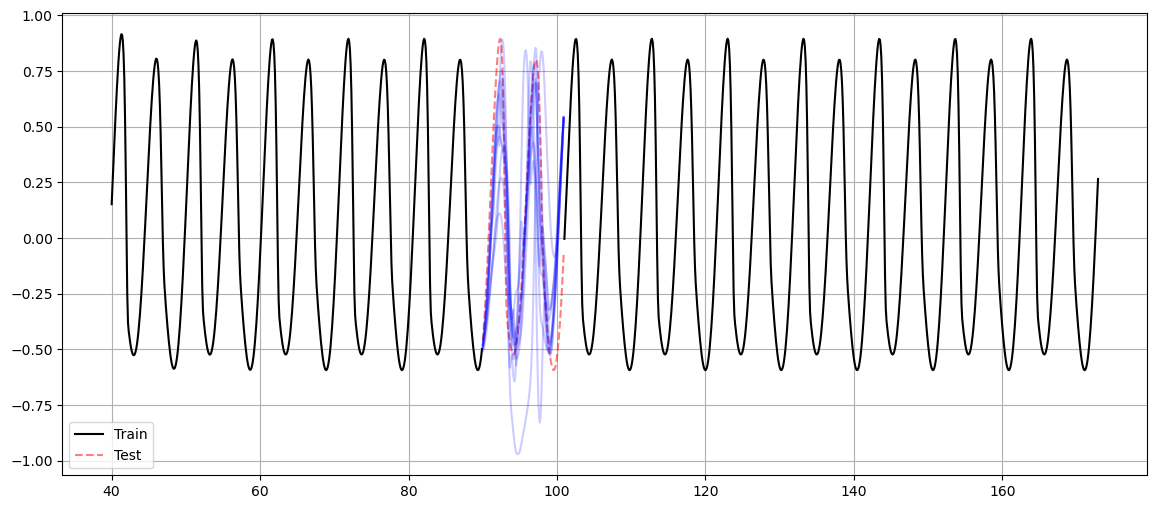

In [32]:
output = np.load('saved_iterations/prediction_mean_weighted.npy')
print(output)

fig = plt.figure(figsize = (14,6))
plt.plot(t_1,raw_seq_1,'k',label='Train')
plt.plot(t_2,raw_seq_2,'k')
plt.plot(t_window,raw_seq_window,'--r',label='Test',alpha=0.5)
for i in range(iterations):
    plt.plot(t_window,output[:,i],'b',alpha=0.2)
plt.grid()
plt.legend()
plt.savefig('figures/rossler_signal_prediction_mean_iteration.png')

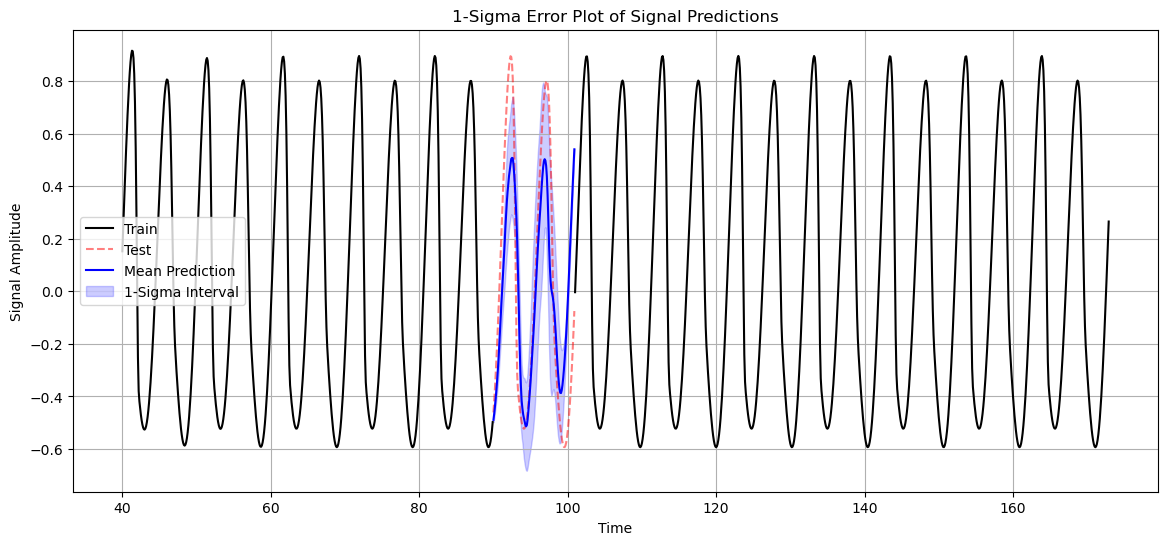

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Load the output signals
output = np.load('saved_iterations/prediction_mean_weighted.npy')

# Create a time vector assuming all signals have the same length
num_steps = output.shape[0]
t = np.linspace(0, num_steps * dt, num_steps)

# Calculate the mean and standard deviation of the predictions
mean_prediction = np.mean(output, axis=1)
std_prediction = np.std(output, axis=1)

# Plot the original signals
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(t_1, raw_seq_1, 'k', label='Train')
ax.plot(t_2, raw_seq_2, 'k')
ax.plot(t_window, raw_seq_window, '--r', label='Test', alpha=0.5)

# Plot the mean prediction
ax.plot(t_window, mean_prediction, 'b', label='Mean Prediction')

# Plot the 1-sigma confidence interval
ax.fill_between(t_window, mean_prediction - std_prediction, mean_prediction + std_prediction, color='blue', alpha=0.2, label='1-Sigma Interval')

# Add grid, legend, and labels
ax.grid()
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Signal Amplitude')
ax.set_title('1-Sigma Error Plot of Signal Predictions')

# Save the figure
plt.savefig('figures/rossler_signal_prediction_1sigma.png')

plt.show()

No handles with labels found to put in legend.


[[-0.49286532 -0.48683581 -0.49482322 ... -0.48351878 -0.49641651
  -0.49084282]
 [-0.47230844 -0.46495544 -0.47162282 ... -0.45897748 -0.48365566
  -0.46011185]
 [-0.44512111 -0.44456792 -0.4529768  ... -0.42543036 -0.46070751
  -0.42597904]
 ...
 [ 0.39377442  0.43479669  0.42832936 ...  0.40769573  0.39436687
   0.45296935]
 [ 0.46561174  0.49022776  0.48549006 ...  0.47567271  0.46801053
   0.50033357]
 [ 0.53541434  0.54529083  0.54070431 ...  0.54184633  0.53660715
   0.54336119]]


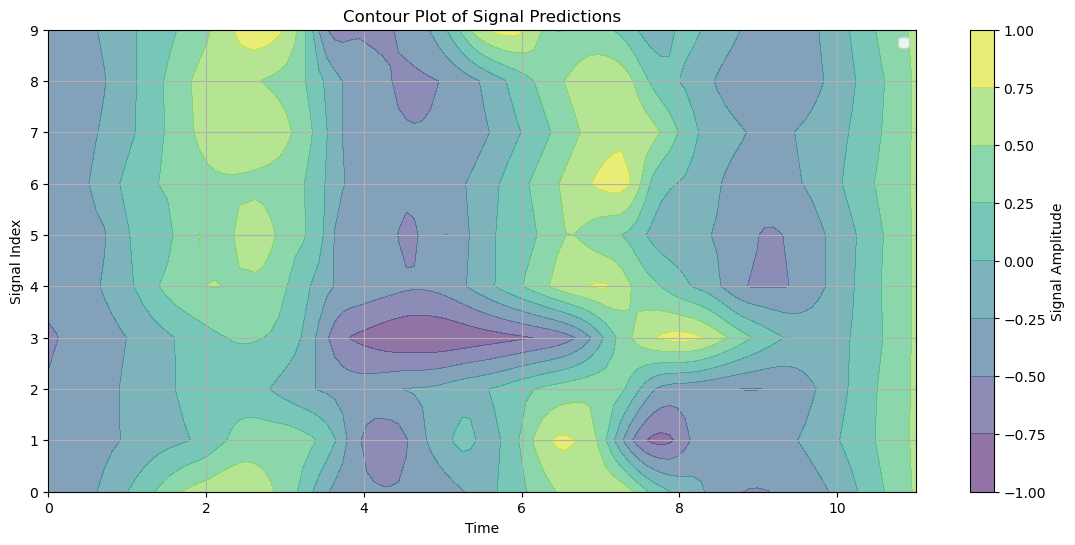

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Load the output signals
output = np.load('saved_iterations/prediction_mean_weighted.npy')
print(output)

# Create a time vector assuming all signals have the same length
num_steps = output.shape[0]
t = np.linspace(0, num_steps * dt, num_steps)

# Create a meshgrid for the contour plot
T, I = np.meshgrid(t, np.arange(output.shape[1]))

# Plot the original signals
fig, ax = plt.subplots(figsize=(14, 6))

# Create the contour plot
contour = ax.contourf(T, I, output.T, cmap='viridis', alpha=0.6)

# Add color bar
cbar = fig.colorbar(contour)
cbar.set_label('Signal Amplitude')

# Add grid, legend, and labels
ax.grid()
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Signal Index')
ax.set_title('Contour Plot of Signal Predictions')

# Save the figure
plt.savefig('figures/rossler_signal_prediction_contour.png')

plt.show()